In [6]:
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv, find_dotenv

In [7]:
load_dotenv(find_dotenv())

True

In [23]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Workflow without LLM

In [12]:
class BMIState(TypedDict):
    weight: int
    height: float
    bmi: float
    category: str

In [4]:
def calculate_bmi(state: BMIState) -> BMIState:
    weight = state["weight"]
    height = state["height"]

    bmi = weight / (height**2)
    state["bmi"] = round(bmi, 2)
    return state

In [ ]:
def label_bmi(state: BMIState) -> BMIState:
    bmi = state["bmi"]

    if bmi < 18.5:
        state["category"] = "under_weight"
    elif 18.5 <= bmi < 25:
        state["category"] = "normal_weight"
    elif 25 <= bmi < 30:
        state["category"] = "over_weight"
    else:
        state["category"] = "obese"
    
    return state

In [15]:
# define the graph
graph = StateGraph(state_schema=BMIState)
# add the nodes
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)
# add the edges
graph.add_edge(START, 'calculate_bmi')
graph.add_edge("calculate_bmi", "label_bmi")
graph.add_edge('label_bmi', END)
# compile the graph
graph = graph.compile()

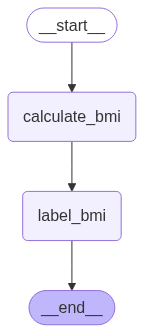

In [16]:
graph

In [17]:
graph.invoke({"weight": 80, "height": 1.73})

{'weight': 80, 'height': 1.73, 'bmi': 26.73, 'category': 'over_weight'}

## LLM Based Workflow

In [18]:
class LLMState(TypedDict):
    question: str
    answer: str

In [24]:
def llm_qa(state: LLMState) -> LLMState:
    question = state["question"]
    prompt = f"Answer the below question as best of your knowledge. \n\n Question: {question}"
    answer = llm.invoke(prompt).content
    state["answer"] = answer

    return state

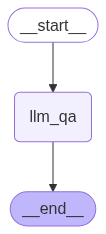

In [25]:
graph = StateGraph(LLMState)
graph.add_node("llm_qa", llm_qa)
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)
graph = graph.compile()

graph

In [26]:
graph.invoke({"question": "How far is moon from the earth?"})

{'question': 'How far is moon from the earth?',
 'answer': "The average distance from the Earth to the Moon is about 238,855 miles (384,400 kilometers). However, this distance can vary slightly due to the Moon's elliptical orbit around the Earth, ranging from about 225,623 miles (363,104 kilometers) at its closest (perigee) to about 252,088 miles (405,696 kilometers) at its farthest (apogee)."}

## Prompt Chaining

In [32]:
class BlogState(TypedDict):
    title: str
    outline: str
    content: str
    eval_score: int

In [33]:
def create_outline(state: BlogState) -> BlogState:
    title = state["title"]
    prompt = f"Generate a detailed outline for a blog on the below mentioned topic. \n\n Topic: {title}"
    outline = llm.invoke(prompt).content
    state["outline"] = outline

    return state


In [34]:
def create_blog(state: BlogState) -> BlogState:
    title = state["title"]
    outline = state["outline"]

    prompt = f"Write a detailed blog on the below mentioned title using the given outline below. \n\n Title: {title} \n\n {outline}"

    content = llm.invoke(prompt).content
    state["content"] = content
    return state

In [35]:
def evaluate_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    content = state['content']

    prompt = f"Based on the below given outline, evaluate the below blog and give the evaluation score out of 5 in integer only. \n\n Outline: {outline} \n\n Blog Content: {content}"

    eval_score = llm.invoke(prompt).content
    state["eval_score"] = eval_score

    return state

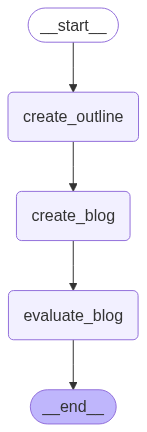

In [36]:
graph = StateGraph(BlogState)
graph.add_node("create_outline", create_outline)
graph.add_node("create_blog", create_blog)
graph.add_node("evaluate_blog", evaluate_blog)

graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', 'evaluate_blog')
graph.add_edge('evaluate_blog', END)

graph = graph.compile()

graph

In [38]:
result = graph.invoke({'title': "Rise of AI in India"})
print(f"Blog Outline: {result['outline']}")
print(f"Blog Content: {result['content']}")
print(f"Blog Eval Score: {result['eval_score']}")

Blog Outline: # Blog Outline: The Rise of AI in India

## Introduction
- Brief overview of AI and its significance in the modern world
- Importance of discussing the rise of AI specifically in India
- Purpose of the blog: to explore the current state, challenges, and future prospects of AI in India

## Section 1: Understanding AI
### 1.1 Definition of Artificial Intelligence
- Explanation of AI and its various branches (machine learning, natural language processing, etc.)
### 1.2 Historical Context
- Brief history of AI development globally
- Key milestones in AI development in India

## Section 2: Current State of AI in India
### 2.1 Government Initiatives
- Overview of government policies and initiatives promoting AI (e.g., National AI Strategy)
- Role of NITI Aayog and other governmental bodies
### 2.2 Industry Growth
- Statistics on AI startups and investments in India
- Key sectors adopting AI (healthcare, agriculture, finance, etc.)
### 2.3 Academic Contributions
- Role of Indian